# Generating Shakespearean Text 
In this exercise, you will train a character-level sequence model on a subset of Shakespeare's works (a single text file), and use it to generate novel text, one charactor at a time according to a distribution learned from the dataset. For this to be effective, we will build our  language model to be stateful, so that the internal state of the RNN will be maintained across batches. 
The Shakespearen Text used in this exercise has 65 classes (total distinct characters) with 1,115,394 characters.

Besides tf.keras that you used previously, you will use the tf.data module preprocessing tools to construct a data ingestion pipeline including batching, shuffing the dataset to train a model to classify the next character. 




In [1]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf # version 2.9.2
from tensorflow import keras
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.layers import TextVectorization, Dense, Flatten, Softmax, Dropout, Embedding, SimpleRNN, LSTM, GRU, Bidirectional

## Data Collection

In [2]:
# download Shakespeare's work from Andreh Karpathy's Char-Rnn Project
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1115394/1115394 [==============================] - 0s 0us/step


## Data Exploration

In [3]:
# explore the length of text and the first 200 charactors in the Shakespeare text
print('Total number of characters in the corpus is:', len(shakespeare_text))
print('The first 200 characters of the corpus are as follows:\n', shakespeare_text[:200])

Total number of characters in the corpus is: 1115394
The first 200 characters of the corpus are as follows:
 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [4]:
# The unique characters in the corpus
vocab = sorted(set(shakespeare_text))
print ('The number of unique characters in the corpus is', len(vocab))
print('A slice of the unique characters set:\n', vocab[:10])

The number of unique characters in the corpus is 65
A slice of the unique characters set:
 ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3']


## Data Preparation

### Vectorizing the shakespeare_text 
Before feeding the text to our model, we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will use TextVectorizatoin layer to tokenize shakespeare text form its vocabulary.  After adapting with its  out of it and replace each character with its index in the vocabulary. 

Note:


*   In this exercise, you can use standardize = None, split='character' as TextVectorization arguments since we might need machine to generate capitalcase and some punctualtion corresponding to Shakespeare styles of writting
*   After vectorizing text, the unique charactors are 67. Since we need meaningful characters, you must renumber the tokenized text by removing padding (index 0) and unknown words (index 1) since we will not genetate them. For example,the tokenized text after text vectorization is <tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([51, 11,  9, ..., 22, 27, 12])>
=> the result of this step must be # tf.Tensor([49  9  7 ... 20 25 10], shape=(1115394,), dtype=int64).
*   We don't have to do one-hot encoding at the final step of preparation since we will use loss as SparseCategoricalCrossentropy.

In [5]:
text_vectorization = TextVectorization(
    standardize = None,
    split='character',
    max_tokens=20000,
    output_mode="int",
)

text_vectorization.adapt([shakespeare_text]) # list that contains string
vocabulary = text_vectorization.get_vocabulary()
print(vocabulary[:5], "with length", len(vocabulary)) # ['', '[UNK]', ' ', 'e', 't'] with length 67
text = text_vectorization([shakespeare_text][0]) # string
print(text) # <tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([51, 11,  9, ..., 22, 27, 12])>

# remove padding (index 0) and unknown words (index 1) since we will not genetate them
text = tf.subtract(text,2)
print(text) # tf.Tensor([49  9  7 ... 20 25 10], shape=(1115394,), dtype=int64)
vocab_size = len(vocabulary) - 2
print("Vocab size:", vocab_size) # Vocab size: 65

['', '[UNK]', ' ', 'e', 't'] with length 67
tf.Tensor([51 11  9 ... 22 27 12], shape=(1115394,), dtype=int64)
tf.Tensor([49  9  7 ... 20 25 10], shape=(1115394,), dtype=int64)
Vocab size: 65


In [6]:
# Create a mapping from indices to unique characters for generating text predicted at inference time
idx2char = idx2char = dict(enumerate(vocabulary[2:]))

### Creating an input and output array
In this part, we will create an input and output array from the list of tokens from Shackspearean text. Let 's specify the length of corresponding input and target array to be the same size of 100 characters (maxlen = 100) and both are overlapped with 1 charactor. (the target is shifted to the right 1 step ahead)
Note: make sure that the input and output array fulfil the following specification:

* Input array and an output array, both of size (num_examples, maxlen). You should have num_examples = 11,153.
* The input array should contain the 100 tokens of each sequence.
* The output array should contain the last 99 characters of input array + 1 (next character token) of each sequence.
* To support model to be stateful, we will sample a new sequence every 100 characters so that the next sequence continue where the previous left off.

In [7]:
maxlen = 100 # extract sequences of 100 characters
shift = 100 # sample a new sequence every 100 characters
sentences = [] # keep the extracted input sequences
target_sentences = [] # keep the output sequences 
for i in range(0, len(text) - maxlen-1, shift):
  sentences.append(text[i:i+maxlen])
  target_sentences.append(text[i+1:i+maxlen+1])
print('Number of sequences:', len(sentences))
sentences = np.array(sentences)
target_sentences = np.array(target_sentences)

Number of sequences: 11153


In [8]:
# explore shape of input and output arrays
print(sentences.shape) # (11154,)
print(target_sentences.shape) # (11154,)

(11153, 100)
(11153, 100)


In [9]:
# explore the first and second training data
print(sentences[0])
print(target_sentences[0])
print(sentences[1])
print(target_sentences[1])

[49  9  7  6  2  0 37  9  2  9 57  1  8 24 10 43  1 18  3  7  1  0 17  1
  0 23  7  3 19  1  1 12  0  4  8 15  0 18 13  7  2  5  1  7 16  0  5  1
  4  7  0 14  1  0  6 23  1  4 28 25 10 10 26 11 11 24 10 35 23  1  4 28
 16  0  6 23  1  4 28 25 10 10 49  9  7  6  2  0 37  9  2  9 57  1  8 24
 10 50  3 13]
[ 9  7  6  2  0 37  9  2  9 57  1  8 24 10 43  1 18  3  7  1  0 17  1  0
 23  7  3 19  1  1 12  0  4  8 15  0 18 13  7  2  5  1  7 16  0  5  1  4
  7  0 14  1  0  6 23  1  4 28 25 10 10 26 11 11 24 10 35 23  1  4 28 16
  0  6 23  1  4 28 25 10 10 49  9  7  6  2  0 37  9  2  9 57  1  8 24 10
 50  3 13  0]
[ 0  4  7  1  0  4 11 11  0  7  1  6  3 11 27  1 12  0  7  4  2  5  1  7
  0  2  3  0 12  9  1  0  2  5  4  8  0  2  3  0 18  4 14  9  6  5 44 10
 10 26 11 11 24 10 34  1  6  3 11 27  1 12 25  0  7  1  6  3 11 27  1 12
 25 10 10 49  9  7  6  2  0 37  9  2  9 57  1  8 24 10 49  9  7  6  2 16
  0 15  3 13]
[ 4  7  1  0  4 11 11  0  7  1  6  3 11 27  1 12  0  7  4  2  5  1  7  0
  2  3  0

In [10]:
# explore the first and second training data
print(" ".join([idx2char[c] for c in sentences[0]]))
print('=================')
print(" ".join([idx2char[c] for c in target_sentences[0]]))
print('=================')
print(" ".join([idx2char[c] for c in sentences[1]]))
print('=================')
print(" ".join([idx2char[c] for c in target_sentences[1]]))

F i r s t   C i t i z e n : 
 B e f o r e   w e   p r o c e e d   a n y   f u r t h e r ,   h e a r   m e   s p e a k . 
 
 A l l : 
 S p e a k ,   s p e a k . 
 
 F i r s t   C i t i z e n : 
 Y o u
i r s t   C i t i z e n : 
 B e f o r e   w e   p r o c e e d   a n y   f u r t h e r ,   h e a r   m e   s p e a k . 
 
 A l l : 
 S p e a k ,   s p e a k . 
 
 F i r s t   C i t i z e n : 
 Y o u  
  a r e   a l l   r e s o l v e d   r a t h e r   t o   d i e   t h a n   t o   f a m i s h ? 
 
 A l l : 
 R e s o l v e d .   r e s o l v e d . 
 
 F i r s t   C i t i z e n : 
 F i r s t ,   y o u
a r e   a l l   r e s o l v e d   r a t h e r   t o   d i e   t h a n   t o   f a m i s h ? 
 
 A l l : 
 R e s o l v e d .   r e s o l v e d . 
 
 F i r s t   C i t i z e n : 
 F i r s t ,   y o u  


###Preprocess sequence array for stateful RNN
We will build RNN language model to be stateful, so that the internal state of the RNN will be maintained across batches. For this to be effective, we need to make sure that each element of every batch follows on from the corresponding element of the preceding batch

The following code processes the input and output sequence arrays so that they are ready to be split into batches for training a stateful RNN, by re-ordering the sequence examples (the rows) according to a specified batch size.<br>
you can read how to process the batchs here https://datascience.stackexchange.com/questions/66164/about-batches-in-stateful-rnn 


In [11]:
# Prepare input and output arrays for training the stateful RNN
batch_size = 32

num_examples = sentences.shape[0] # 11153

num_processed_examples = num_examples - (num_examples % batch_size) # 11136

sentences = sentences[:num_processed_examples] # shape = (11136, 100)
target_sentences = target_sentences[:num_processed_examples] # shape = (11136, 100)

steps = int(num_processed_examples / 32)  # steps per epoch
#print(steps) # 348
inx = np.empty((0,), dtype=np.int32)
for i in range(steps):
    #print(i,np.arange(0, num_processed_examples, steps)
    inx = np.concatenate((inx, i + np.arange(0, num_processed_examples, steps)))

#print(inx) # [0,   348,   696, ..., 10439, 10787, 11135]
sentences_stateful = sentences[inx] # re-ordering so that the seqeunce are process consecutively 
# you can read how to process the batchs here https://datascience.stackexchange.com/questions/66164/about-batches-in-stateful-rnn 
target_sentences_stateful = target_sentences[inx]

### Split the data
In this exercise, let' split the data into training set, validation set and test set with the proportion of 70:20:10 percents.

In [12]:
train_size = int(batch_size * ((0.7 * num_processed_examples) // batch_size))
val_size = int(batch_size * ((0.9 * num_processed_examples) // batch_size))

input_train = sentences_stateful[:train_size]
target_train = target_sentences_stateful[:train_size]
input_val = sentences_stateful[train_size:val_size]
target_val = target_sentences_stateful[train_size:val_size]
input_test = sentences_stateful[val_size:]
target_test = target_sentences_stateful[val_size:]

In [13]:
input_train.shape, input_val.shape, input_test.shape

((7776, 100), (2240, 100), (1120, 100))

###Creating the TensorFlow Dataset
In this exercise, we will utiize the Dataset from TensorFlow. This is achieved by using tf.data.Dataset to create the dataset object in tensorflow that has a rich set of processing tools to process the data. In this part, you will write the function that create a Dataset using the from_tensor_slices static method, passing in a tuple of the input and output numpy arrays and we will split them into batchs, setting drop_remainder to True. The function should then return the Dataset object.

In [14]:
# Complete the following function.
# Make sure not to change the function name or arguments.

def make_Dataset(input_array, target_array, batch_size):
    """
    This function takes a numpy array batch of input data in the first argument, and
    a corresponding array containing the labels in the second argument, and an integer
    batch_size in the third argument. It should create and return a Dataset object 
    using the two numpy arrays and batch size according to the above specification.
    """
    dataset = tf.data.Dataset.from_tensor_slices((input_array, target_array))
    # Generate batched sequences out of the dataset.
    dataset = dataset.batch(batch_size, drop_remainder=True)
    
    # code for shuffling with in a batch size (optional)
    # buffer_size = 10000
    # dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)
    return dataset

In [15]:
# Create the training and validation Datasets

dataset = make_Dataset(input_train, target_train, batch_size)
val_dataset = make_Dataset(input_val, target_val, batch_size)
test_dataset = make_Dataset(input_test, target_test, batch_size)

In [16]:
print(dataset.element_spec)
print(val_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(32, 100), dtype=tf.int64, name=None), TensorSpec(shape=(32, 100), dtype=tf.int64, name=None))
(TensorSpec(shape=(32, 100), dtype=tf.int64, name=None), TensorSpec(shape=(32, 100), dtype=tf.int64, name=None))
(TensorSpec(shape=(32, 100), dtype=tf.int64, name=None), TensorSpec(shape=(32, 100), dtype=tf.int64, name=None))


In [17]:
# take - fetch 5 samples
for X_batch, Y_batch in dataset.take(5):
    print(X_batch.shape, Y_batch.shape)

(32, 100) (32, 100)
(32, 100) (32, 100)
(32, 100) (32, 100)
(32, 100) (32, 100)
(32, 100) (32, 100)


## Modelling
Let's build your language model. The model will receive a sequence of characters and predict the next character in the sequence. At training time, the model can be passed an input sequence, with the output sequence is shifted by one.

For example, <br>
Input: "How are y?" Output: "ow are yo" <br>
Note the Output is the same length as the input
<br>
In this part, we will let you complete the function that takes arguments for the vocabulary size (number of tokens) and batch size. Using the Sequential API, your function should build your model according to the following specifications: (In total, the network should have 3 layers.)

* The first layer should be an Embedding layer with an  embedding dimension of 256 and set the vocabulary size to vocab_size from the function argument.
* The Embedding layer should also mask the zero padding in the input sequences.
* The Embedding layer should also set the batch_input_shape to (batch_size, None) (a fixed batch size is required for stateful RNNs).
* The next layer should be a (uni-directional) GRU layer with 1024 units, set to be a stateful RNN layer.
* The GRU layer should return the full sequence, instead of just the output state at the final time step.
* The final layer should be a Dense layer with vocab_size units and no activation function since we use from sparse categorical cross entropy loss with logit=True to reduce softmax computation.


In [18]:
def get_model(vocab_size, batch_size):
    """
    This function takes a vocabulary size and batch size, and builds and returns a 
    Sequential model according to the above specification.
    """
    model = tf.keras.Sequential(
        [
         Embedding(vocab_size, 256, mask_zero=True, batch_input_shape=(batch_size, None)),
         GRU(1024, stateful=True, return_sequences=True),
         Dense(vocab_size)
        ]
    )

    
    return model

In [19]:
vocab_size = len(vocab) # no. of unique characters
batch_size = 32

model = get_model(vocab_size, batch_size)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           16640     
                                                                 
 gru (GRU)                   (32, None, 1024)          3938304   
                                                                 
 dense (Dense)               (32, None, 65)            66625     
                                                                 
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


In [20]:
# compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['acc'])

In [21]:
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath='./models/ckpt',
                                                           save_weights_only=True,
                                                           save_best_only=True)

csvlog_callback=tf.keras.callbacks.CSVLogger('history')

history = model.fit(dataset, epochs=20,validation_data=val_dataset,callbacks=[checkpoint_callback, csvlog_callback])

Epoch 1/20
243/243 [==============================] - 1112s 5s/step - loss: 2.1365 - acc: 0.3092 - val_loss: 1.7150 - val_acc: 0.4056
Epoch 2/20
243/243 [==============================] - 1082s 4s/step - loss: 1.5135 - acc: 0.4720 - val_loss: 1.3621 - val_acc: 0.5243
Epoch 3/20
243/243 [==============================] - 1014s 4s/step - loss: 1.2369 - acc: 0.5621 - val_loss: 1.1799 - val_acc: 0.5821
Epoch 4/20
243/243 [==============================] - 1023s 4s/step - loss: 1.0839 - acc: 0.6102 - val_loss: 1.0946 - val_acc: 0.6106
Epoch 5/20
243/243 [==============================] - 983s 4s/step - loss: 0.9839 - acc: 0.6410 - val_loss: 1.0543 - val_acc: 0.6235
Epoch 6/20
243/243 [==============================] - 1048s 4s/step - loss: 0.9051 - acc: 0.6660 - val_loss: 1.0386 - val_acc: 0.6306
Epoch 7/20
243/243 [==============================] - 1115s 5s/step - loss: 0.8348 - acc: 0.6889 - val_loss: 1.0445 - val_acc: 0.6300
Epoch 8/20
243/243 [==============================] - 1121s 5s/

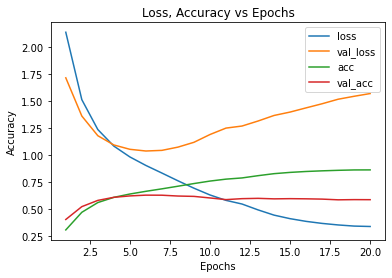

In [22]:
#plot the learning curves
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'], label = 'loss')
plt.plot(epochs, history.history['val_loss'], label = 'val_loss')
plt.plot(epochs, history.history['acc'], label = 'acc')
plt.plot(epochs, history.history['val_acc'], label = 'val_acc')
plt.title('Loss, Accuracy vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [23]:
# measure the accuracy at test set
model.evaluate(test_dataset)

35/35 [==============================] - 26s 754ms/step - loss: 1.5872 - acc: 0.5839


[1.5871989727020264, 0.5838709473609924]

### Generate New Text 
In this part, you will use the model to generate text. However, in order to generate a single text sequence, the model needs to be rebuilt with a batch size of 1. (Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.). After building the model, we will feed the single sequence to the model to predict the most likely next letter, add it at the end of the text, then give the extended text to the model to guess the next letter, and so on. These are steps you need to do:
1. Restore the latest checkpoint. To keep this prediction step simple, use a batch size of 1. To run the model with a different batch_size which in case is 1, we need to rebuild the model and restore the weights from the checkpoint. 
2.Prediction the next token based on sampling distribution

In [24]:
model = get_model(vocab_size, batch_size=1)
model.load_weights(tf.train.latest_checkpoint('./models/'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            16640     
                                                                 
 gru_1 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_1 (Dense)             (1, None, 65)             66625     
                                                                 
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


### The prediction loop
The following code block generates the text:

It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate. In order to predict the next token, we will get the prediction distribution of the next character using the start string and the RNN state. Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one character. After predicting the next character, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted characters

In [25]:
def generate_text(model, num_generate, temperature, start_string):
  input_eval = text_vectorization(start_string) # string to numbers (vectorizing)
  input_eval -= 2 # to remove padding and unknown tokens
  input_eval = tf.expand_dims(input_eval, 0) # dimension expansion at axis0 () 
  text_generated = [] # Empty string to store our results
  model.reset_states() # Clears the hidden states in the RNN

  for i in range(num_generate): #Run a loop for number of characters to generate
    predictions = model(input_eval) # prediction for single character
    predictions = tf.squeeze(predictions, 0) # remove the batch dimension
    
    # using a categorical distribution to predict the character returned by the model
    # higher temperature increases the probability of selecting a less likely character
    # lower --> more predictable
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    # The predicted character as the next input to the model
    # along with the previous hidden state
    # So the model makes the next prediction based on the previous character
    input_eval = tf.expand_dims([predicted_id], 0) 
    # Also devectorize the number and add to the generated text
    text_generated.append(idx2char[predicted_id]) 

  return (start_string + ''.join(text_generated))

In [26]:
generated_text = generate_text(
                    model, 
                    num_generate=500, 
                    temperature=0.2, 
                    start_string=u"First Citizen")
print(generated_text)

First Citizens,
And for Lord Clifford and Signior Prince,
That France know Upon 
The Senate $ Now I Do th ! :
I  Jon so, zenona : ?

CLARENCE:
Then 3 $ar for 
A amelled, cousin for Securate William.

CLARENCE:
The join 3 be Zount's ence, very William venture.

KING DENRY quencle, 3 ay, I 
marry may Zouncillain ERward 
And Stand York , : know A age llow Sand France,
That xarting s England Warwick have Warwick xather country's country,
It  just 's -wounds in the Unless Richard I God Bickly Send Henry.

BRAKENB
